In [22]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar 

# Load data
df_recipes = pd.read_pickle("../../Data/RAW_recipes_local.pkl")
df_recipes.head(5)

%matplotlib inline

In [50]:
# Select feature of interest from raw data
feat_name = "date"
df_dates = df_recipes[[feat_name]]

# ----------------------------------------------------------------------
# Converting from strings to datetime format
# ----------------------------------------------------------------------
# errors = "coerce" => Invalid parsing will be set to NaT (Not a Time)
df_dates["date"] = pd.to_datetime(df_dates["date"], errors="coerce")
# Remove missing files
df_dates = df_dates.dropna()

df_dates.head(10)

print(type(df_dates))
df_dates["year"] = df_dates[feat_name].dt.year
#df_dates["month"] = df_dates[feat_name].dt.month_name()
#df_dates["month_num"] = df_dates[feat_name].dt.month
#df_dates["day"] = df_dates[feat_name].dt.day_name()
#df_dates["day_num"] = df_dates[feat_name].dt.dayofweek

df_dates.head(10)

<class 'pandas.core.frame.DataFrame'>


/tmp/ipykernel_8157/795215808.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates["date"] = pd.to_datetime(df_dates["date"], errors="coerce")


,date,year
0,2003-02-17,2003
1,2011-12-21,2011
2,2002-12-01,2002
3,2010-02-27,2010
4,2011-10-01,2011
5,2005-05-21,2005
6,2011-08-06,2011
7,2015-05-10,2015
8,2005-09-02,2005
9,2005-12-22,2005


# **Annual data frequencies**

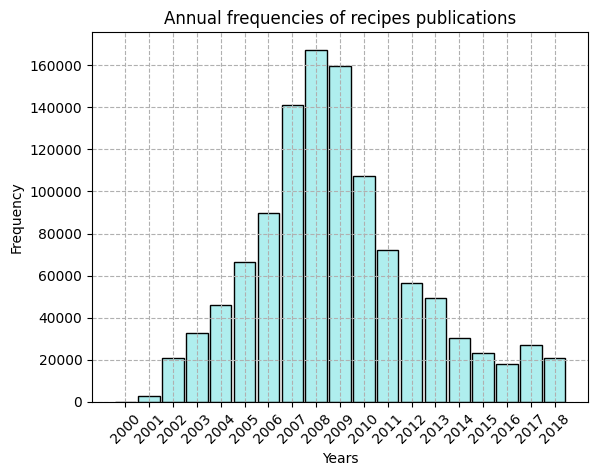

In [55]:
# Retrieve years data as series (not as a dataframe) while removing missing values
years = df_dates["year"].dropna()   

# Generate histogram
bins = range(int(years.min()), int(years.max()) + 2)    # Compute bins so each bin belongs to a year
plt.hist(years, bins=bins, align="left",color="paleturquoise", edgecolor="black", rwidth=0.9)

# Each horizontal axis matches a separate year
plt.xticks(range(int(years.min()), int(years.max()) + 1))
plt.tick_params(axis='x', labelrotation=45)

plt.title("Annual frequencies of recipes publications")
plt.ylabel("Frequency")
plt.xlabel("Years")
plt.grid(True, linestyle='--', alpha=1)

# **Compare up to 3 days within a year interval**

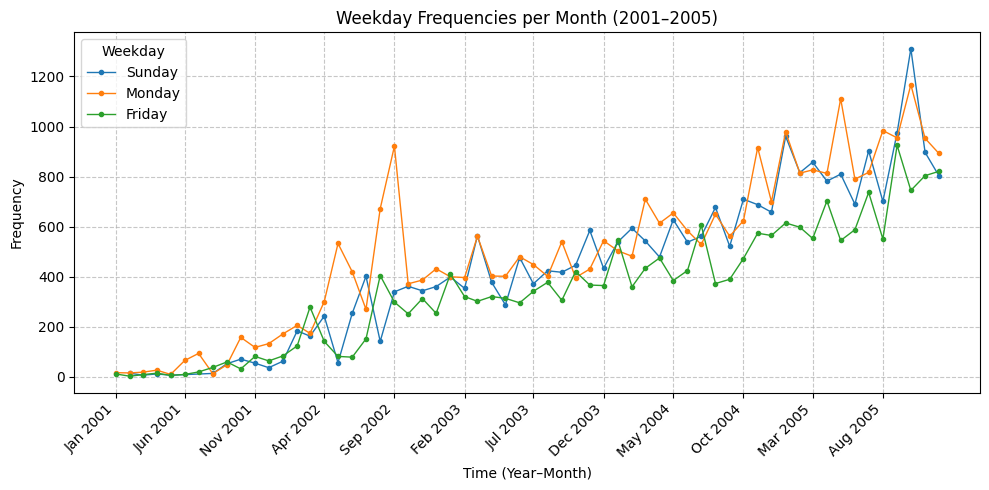

In [58]:
# Parameters
year_start = 2001
year_end   = 2005
weekdays   = ["Sunday", "Monday","Friday"]   # 👈 list of weekdays you want to compare

# Clean up data
#df = df_dates.copy()
#df["date"] = pd.to_datetime(df["date"], errors="coerce")
#df = df.dropna(subset=["date"])

# Filter by year interval
mask_years = df_dates["date"].dt.year.between(year_start, year_end)
df_new_dates = df_dates.loc[mask_years]

# Prepare figure
plt.figure(figsize=(10, 5))

# Loop over each weekday and plot its curve
for day in weekdays:
    mask_day = df_new_dates["date"].dt.day_name() == day
    df_filtered = df_new_dates.loc[mask_day, ["date"]].copy()

    # Retrieve years and add a column
    df_filtered["year"]  = df_filtered["date"].dt.year
    # Retrieve months and add a column
    df_filtered["month"] = df_filtered["date"].dt.month

    # Creates dataframe with the montyly counts
    monthly_counts = (
        df_filtered
        .groupby(["year", "month"])
        .size()
        .reset_index(name="count")
    )

    # Create labels for the horizontal axis
    # The "-01" at the and is just to provide complete data to the to_datetime() function
    monthly_counts["date_label"] = pd.to_datetime(
        monthly_counts["year"].astype(str) + "-" + monthly_counts["month"].astype(str) + "-01"
    )

    # Plot curve for this weekday
    plt.plot(
        monthly_counts["date_label"], monthly_counts["count"],
        marker=".", linewidth = 1, label = day
    )

# Format the chart
plt.title(f"Weekday Frequencies per Month ({year_start}–{year_end})")
plt.xlabel("Time (Year–Month)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.7)

# Format x-axis labels
plt.xticks(
    monthly_counts["date_label"][::5],
    [d.strftime("%b %Y") for d in monthly_counts["date_label"][::5]],
    rotation=45, ha="right"
)

plt.legend(title="Weekday")
plt.tight_layout()

# **Monthly frequency for a specific day through one year**

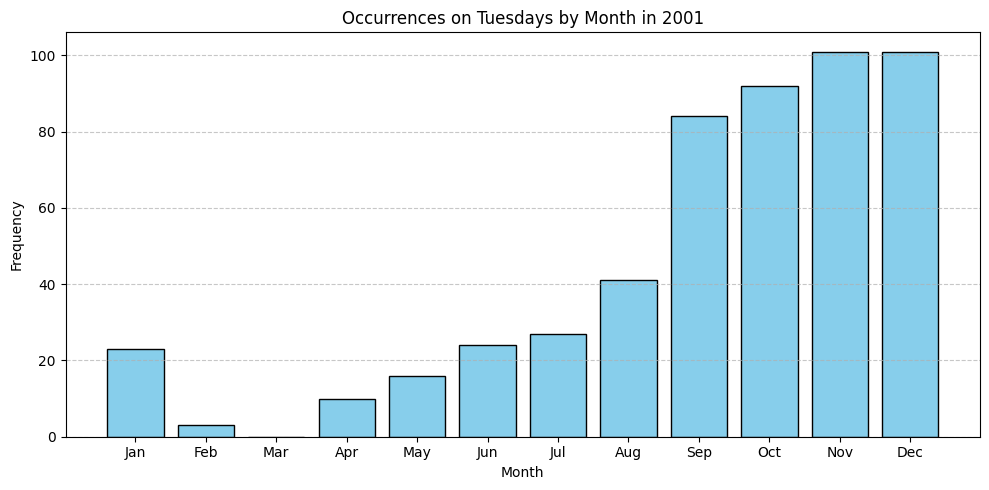

In [46]:
my_year = 2001
my_week_day = "Tuesday"

# Use of a boolean mask to filter rows for that year & weekday
mask = (df_dates['date'].dt.year == my_year) & (df_dates['date'].dt.day_name() == my_week_day)

by_month = (
    # Use loc to select only column 'date' for the rows where the mask is true
    df_dates.loc[mask, 'date']
    # Extract the month number [1, 1, 2, 3, 5, ...] (a series)
    .dt.month
    # Counts how many times each month number appears
    .value_counts()
    # Ensures all months (1-12) are present
    .reindex(range(1, 13), fill_value=0)
)

# ----------------------------------------------------------------------
# PLot
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(by_month.index, by_month.values, color="skyblue", edgecolor="black", width=0.8)
plt.xticks(range(1, 13), calendar.month_abbr[1:], rotation=0)
plt.title(f"Occurrences on {my_week_day}s by Month in {my_year}")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# **Monthly frequency for a specific day through within a year interval**

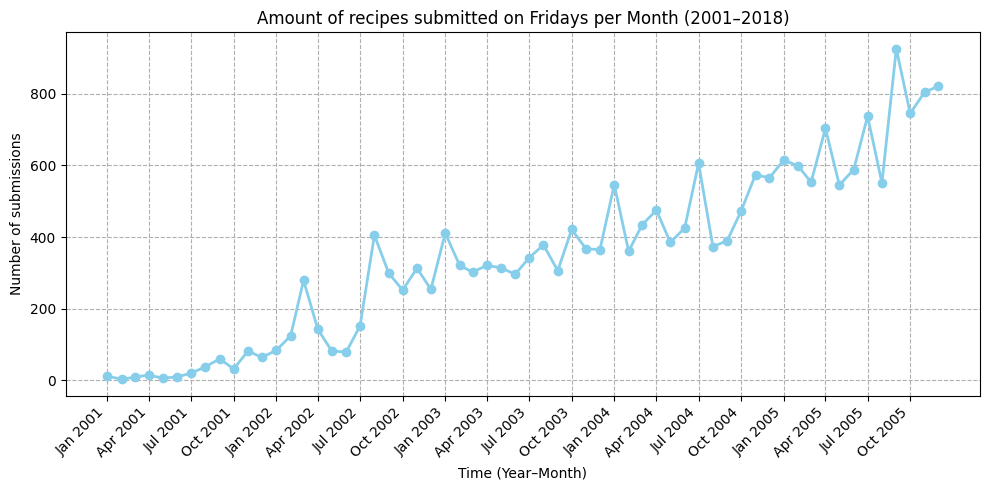

In [48]:
year_start = 2001
year_end = 2018
my_week_day = "Friday"

# Remove rows with any missing values
df_dates = df_dates.dropna()

# Filter rows with the year interval and weekday
mask = ((df_dates['date'].dt.year >= year_start) & (df_dates['date'].dt.year <= year_end) & (df_dates['date'].dt.day_name() == my_week_day))

# Dataframe containing only e.g. "Fridays" between year_start and year_end
df_filtered = df_dates.loc[mask, ["date"]].copy()

# --- Compute monthly counts ---
df_filtered["year"] = df_filtered["date"].dt.year
df_filtered["month"] = df_filtered["date"].dt.month

# Count how many Fridays per month
monthly_counts = (
    df_filtered.groupby(["year", "month"]).size()
    .reset_index(name="count")
)

# Build a continuous date index (YYYY-MM as one time axis)
monthly_counts["date_label"] = pd.to_datetime(
    monthly_counts["year"].astype(str) + "-" + monthly_counts["month"].astype(str) + "-01"
)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(monthly_counts["date_label"], monthly_counts["count"],
         marker="o", linewidth=2, color="skyblue")

plt.title(f"Amount of recipes submitted on {my_week_day}s per Month ({year_start}–{year_end})")
plt.xlabel("Time (Year–Month)")
plt.ylabel("Number of submissions")
plt.grid(True, linestyle="--", alpha=1)

# Format x-axis
plt.xticks(monthly_counts["date_label"][::3],  # show one tick every 3 months
           [d.strftime("%b %Y") for d in monthly_counts["date_label"][::3]],
           rotation=45, ha="right")

plt.tight_layout()
plt.show()

# **Monthly frequencies for a specific year**

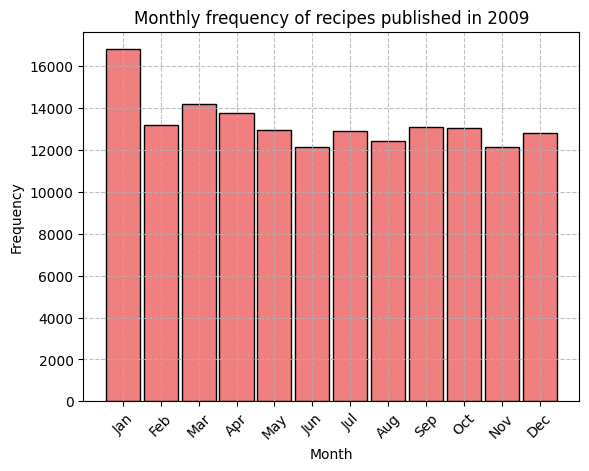

In [20]:
specific_year = 2009
df_year = df_dates[df_dates["year"] == specific_year]

# Extract months as numbers (1–12)
months = df_year[feat_name].dt.month

plt.hist(months, bins=range(1, 14), align="left",color="lightcoral", edgecolor="black", rwidth=0.9)

plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 
           rotation=45)

plt.title(f"Monthly frequency of recipes published in {specific_year}")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.8)
plt.show()

# **Monthly frequencies for all years available**

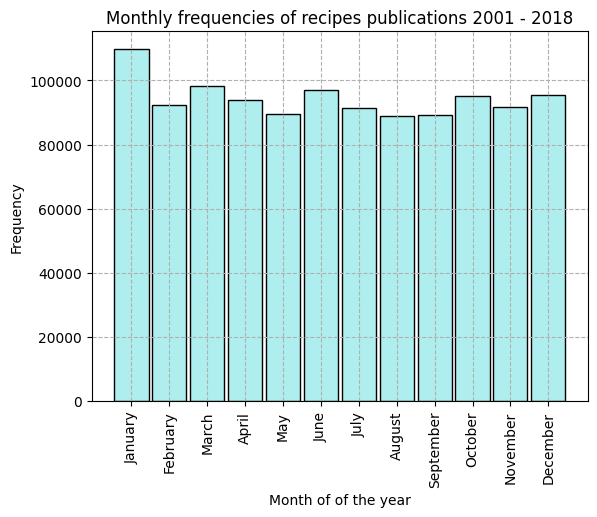

In [10]:
%matplotlib inline
# Retrieve years data as series (not as a dataframe) while removing missing values
months = df_dates["month_num"].dropna()   

# Generate histogram
bins = range(int(months.min()), int(months.max()) + 2)    # Compute bins so each bin belongs to a year
plt.hist(months, bins=bins, align="left",color="paleturquoise", edgecolor="black", rwidth=0.9)

# Each horizontal axis matches a separate year
plt.xticks(range(int(months.min()), int(months.max()) + 1))
#plt.tick_params(axis='x', labelrotation=45)
plt.xticks(range(1, 13), calendar.month_name[1:], rotation=90)


plt.title("Monthly frequencies of recipes publications 2001 - 2018")
plt.ylabel("Frequency")
plt.xlabel("Month of of the year")
plt.grid(True, linestyle='--', alpha=1)

# **Daily frequencies for all years available**

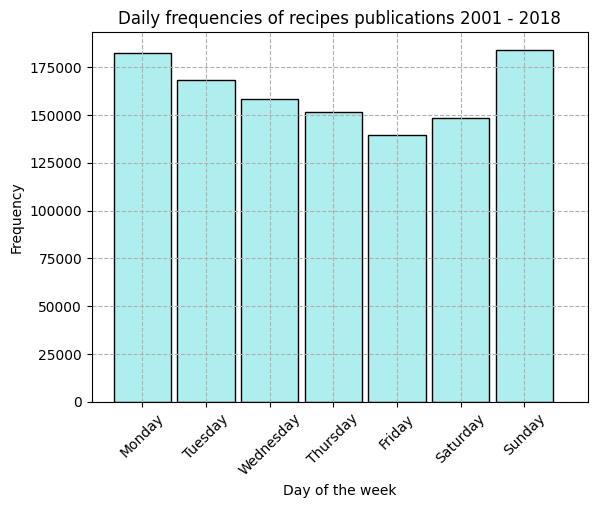

In [73]:
# Retrieve years data as series (not as a dataframe) while removing missing values
days = df_dates["day_num"].dropna()

# Generate histogram
bins = range(0,8) 
plt.hist(days, bins=bins, align="left",color="paleturquoise", edgecolor="black", rwidth=0.9)

# Each horizontal axis matches a separate day of the week
plt.xticks(range(0,7 + 1))
plt.xticks(range(0, 7), calendar.day_name, rotation=45)

plt.title("Daily frequencies of recipes publications 2001 - 2018")
plt.ylabel("Frequency")
plt.xlabel("Day of the week")
plt.grid(True, linestyle='--', alpha=1)